In [5]:
import cv2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import feature, filters, io, morphology, measure, color, draw,transform, util

In [6]:
def delete_duplicity(df):
    df = df.drop_duplicates(subset = ["x"],keep='last')
    for i in range(-1,df.shape[0]):
        try:
            first_cord = df['x'][i]
            second_cord = df['x'][i+1]
            #print("First > {} , Second > {}".format(first_cord, second_cord))

            if (first_cord - second_cord) < 0:
                if(second_cord - first_cord) < 12:
                    #print("Yes, different between > {}".format(second_cord - first_cord))
                    df = df.drop(df.index[i])
                    df = df.sort_values(by = ['x'])
                    df = df.reset_index(drop=True)

            else:
                #print("another difference")
                pass

        except:
            pass

    return df

In [7]:
def marek_toth(image):
    pure_img = io.imread(image)
    Img = (plt.imread(image)*255).astype(dtype=np.uint8)
    I_lab = color.rgb2lab(Img)
    io.imshow(pure_img)
    X = np.logical_and(I_lab[:, :, 1] > -40, I_lab[:, :, 1] < -15)
    Y = np.logical_and(I_lab[:, :, 2] > -20, I_lab[:, :, 2] < 5)
    mask = np.logical_and(X, Y)
    plt.figure(figsize=(15, 10))
    plt.imshow(color.lab2rgb(I_lab*np.repeat(mask[...,None],3,axis=2)))
    plt.show()

    only_red = color.lab2rgb(I_lab*np.repeat(mask[...,None],3,axis=2))
    only_red = color.rgb2gray(only_red)
    
    sobel = filters.sobel(only_red)
    eroded = morphology.erosion(only_red, morphology.disk(1))
    gray = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
                                
    io.imshow(sobel)
                                
    edges = sobel
    diameter_x = 10
    diameter_y = 15
    num_peaks = 30
    hough_radii = np.arange(diameter_x,diameter_y, 1)
    hough_res = transform.hough_circle(edges, hough_radii)
    
    points_x,points_y, radius_c = [],[],[]

    accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,total_num_peaks = num_peaks)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image = color.gray2rgb(gray)
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = draw.circle_perimeter(center_y, center_x, radius, shape=image.shape)
        image[circy, circx] = (255, 0, 0)
        points_x.append(center_x)
        points_y.append(center_y)
        radius_c.append(radius)

    ax.imshow(image, cmap=plt.cm.gray)
    plt.show()
    
    df = pd.DataFrame(list(zip(points_x, points_y)),columns=['x','y'])
    
    for i in range(0,10):
        df = delete_duplicity(df)
    
    num_reds = len(df['x'])
    coordinates = [df['x'],df['y'],radius]
    
    print("Number of red mms {}\n".format(num_reds))
    
    for i in range(0, len(df['x'])):
        print("x{} > {}, y{} > {}, radius > {}".format(i+1,df['x'][i],i+1,df['y'][i],radius))
    
    return num_reds, coordinates

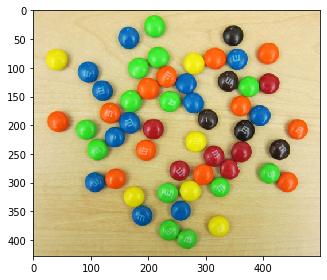

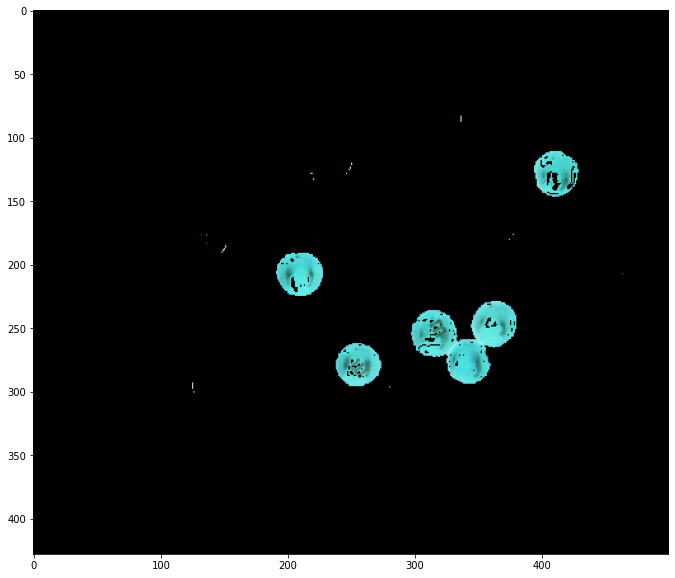

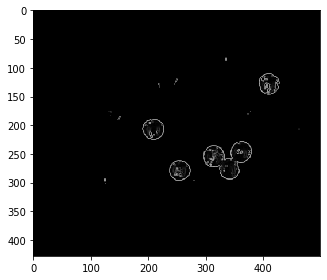

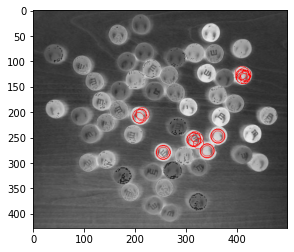

Number of red mms 6

x1 > 214, y1 > 204, radius > 11
x2 > 255, y2 > 279, radius > 11
x3 > 324, y3 > 262, radius > 11
x4 > 341, y4 > 276, radius > 11
x5 > 362, y5 > 247, radius > 11
x6 > 417, y6 > 128, radius > 11


In [8]:
classifier = marek_toth("mms.jpg")